# DataFest@Integration 2023 Problem 1 : Classification of Whale Sounds 
### Team Name: **Aleph 0**
### Members:-
- [Mrinmoy Banik](rinmoybanik12@gmail.com) 
- [Arghya Sarkar](arghyamesarkar@gmail.com)
- [Akshita Gupta](akshitagupta2k@gmail.com)

# Overview
The dataset is downloaded locally in the same directory as this nnotebook with the following file structure:-
        
        ├── .dist
        ├── generated images
        │   ├── test
        │   │   ├── 0
        │   │   └── 1
        │   └── train
        │       ├── 0
        │       └── 1
        ├── Models
        │   ├── Archetecture
        │   └── Weights
        ├── Submissions
        ├── test
        │   └── test
        ├── Tiger Pugmarks
        └── train
            └── train
                ├── 0
                └── 1

We entirely used tensorflow for all our predictions. First sequential audio data is transformed to image form by Short Term Fourier Transform using tensorflow's stft().Next a simple 3-4 layer CNN model with 2 hidden layer MLP was fitted with this spectograms as images data. Lastly the hyperparameters like the stft window length, window step,the no. of samples for computing the fft,length of audio seq and model structure are tweaked to reach 99.77 for 87 accuracy on validation data.  

# Import All necessary libraries

In [253]:
import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow_io as tfio
from tensorflow.keras import layers,models
from IPython import display

# Setup and import dataset

In [254]:
# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
# save the relative or absolute path to the train directory 
train_dir = pathlib.Path('train/train/')
labels = np.array(tf.io.gfile.listdir(str(train_dir)))
print('Labels:', labels)

Labels: ['0' '1']


In [255]:
# lazily load the dataset using tensorflow's DatasetLoader
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=train_dir,
    batch_size=64,
    validation_split=0.1,  # trian:validation split is set to 90:10
    seed=0,
    output_sequence_length=64000, #each audio sequence is resized to 64k samples
    subset='both'
)
label_names = np.array(train_ds.class_names)
print()
print("Label names:", label_names)

Found 25946 files belonging to 2 classes.
Using 23352 files for training.
Using 2594 files for validation.

Label names: ['0' '1']


In [256]:
tf.data.experimental.cardinality(train_ds)

<tf.Tensor: shape=(), dtype=int64, numpy=365>

The Batch size is 64 hence there are 365 batches.Each batch has shape((64,64000),(64)) where the 1st element is a tensor of 63 audio tensors of length 64000 and the 2nd one are it's labels.

In [257]:
#the last dimension of the dataset is removed 
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels
# function applied to dataset objects lazily
train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [258]:
# dataset is divided equally into 2 parts for teating and validation
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [259]:
# one datapoint is inspected to determineshape information (batch_size,no. of audio samples)
for eg_audio, eg_lab in train_ds.take(1):  
  print(eg_audio.shape)
  print(eg_lab.shape)

(64, 64000)
(64,)


# Visualization and Inspection


In [260]:
#function returning the short term fourier transform of the audio signal after taking it's mod
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(waveform,frame_length=65,frame_step=30,fft_length=64)#(65,30)(70,40)
  # spectrogram=tf.signal.mdct(waveform, frame_length=68) #alternatively Modefied Discrete Fourier Transform can also be used
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # spectrogram=tfio.audio.freq_mask(spectrogram, param=2) #image data can be augmented by randomly masking some frequency
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

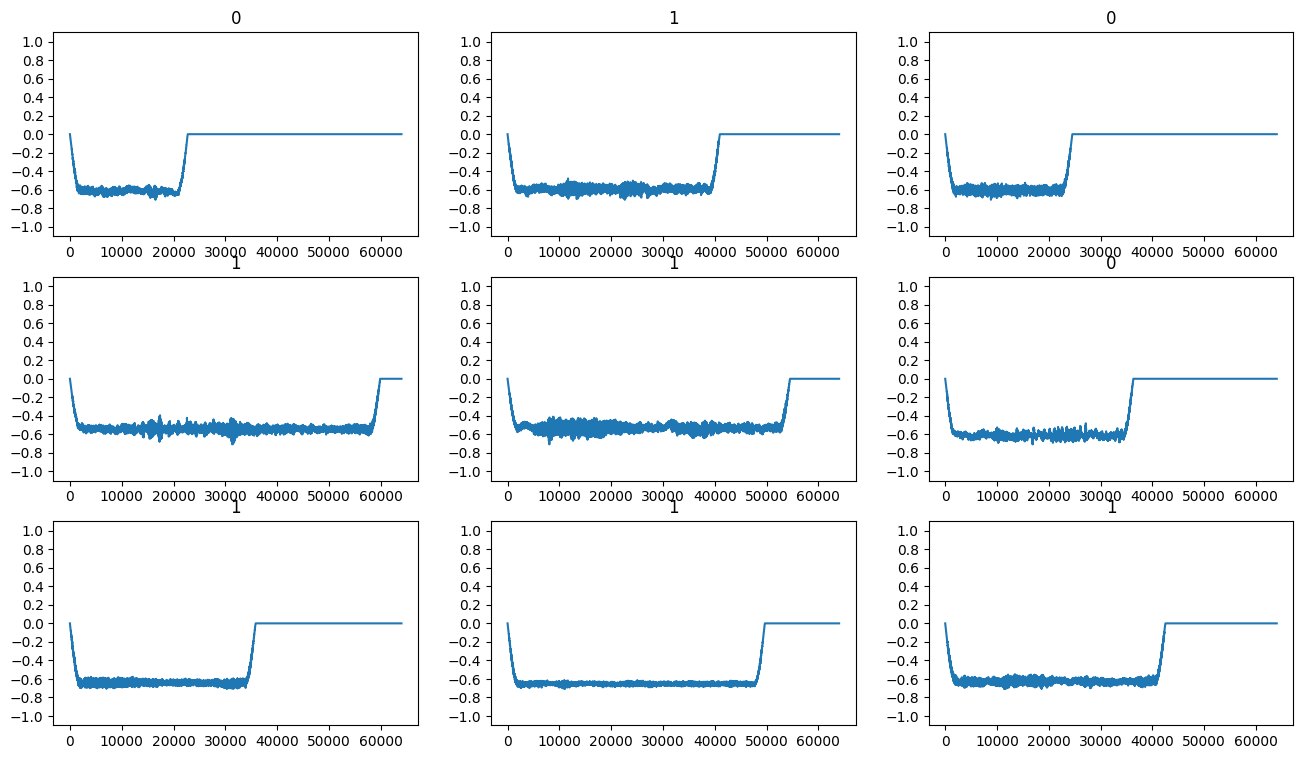

Label: 0
Waveform shape: (64000,)
Spectrogram shape: (2132, 33, 1)
Audio playback


Label: 1
Waveform shape: (64000,)
Spectrogram shape: (2132, 33, 1)
Audio playback


Label: 0
Waveform shape: (64000,)
Spectrogram shape: (2132, 33, 1)
Audio playback


In [261]:
#First few audio samples are plotted as time aplitude plot along with corresponding spectogram and playbacks.
def viz(audio,labels):
  rows = 3
  cols = 3
  n = rows * cols
  fig, axes = plt.subplots(rows, cols, figsize=(16, 9))
  for i in range(n):
    if i>=n:
      break
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    ax.plot(audio[i].numpy())
    ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
    label = label_names[labels[i]]
    ax.set_title(label)
    ax.set_ylim([-1.1,1.1])
  plt.show()
  for i in range(3):
    label = label_names[eg_lab[i]]
    waveform = eg_audio[i]
    spectrogram =get_spectrogram(waveform)
    print('Label:', label)
    print('Waveform shape:', waveform.shape)
    print('Spectrogram shape:', spectrogram.shape)
    print('Audio playback')
    display.display(display.Audio(waveform,rate=16000))
viz(eg_audio,eg_lab)

In [262]:
def plot_spectrogram(spectrogram,ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

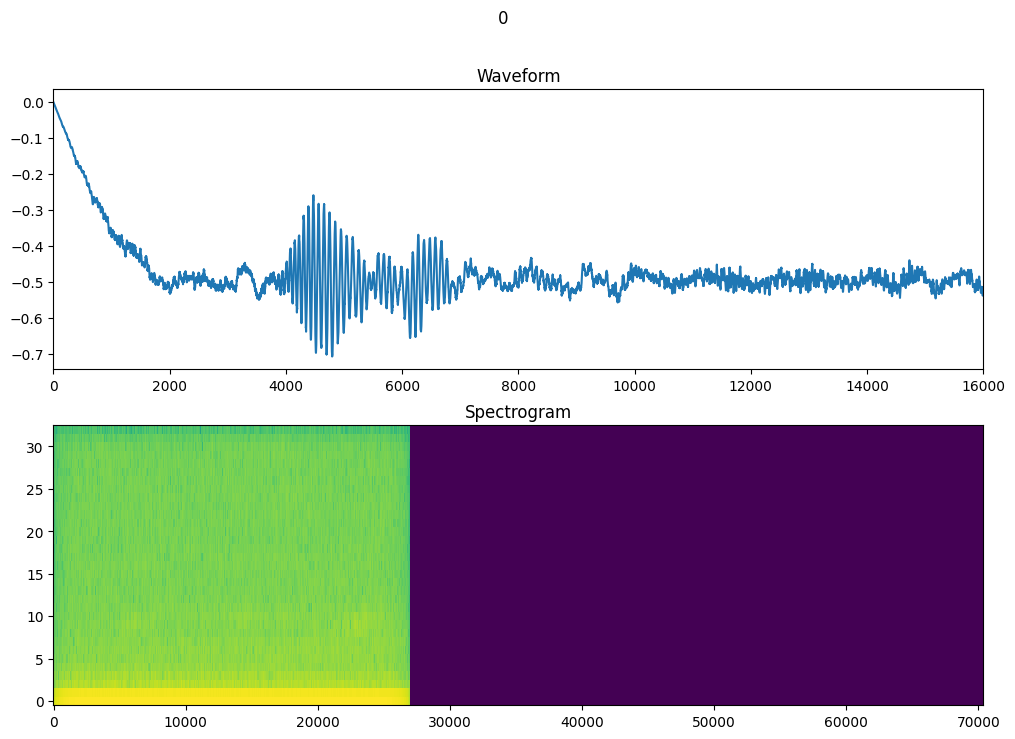

In [263]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

In [264]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label:(get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [265]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

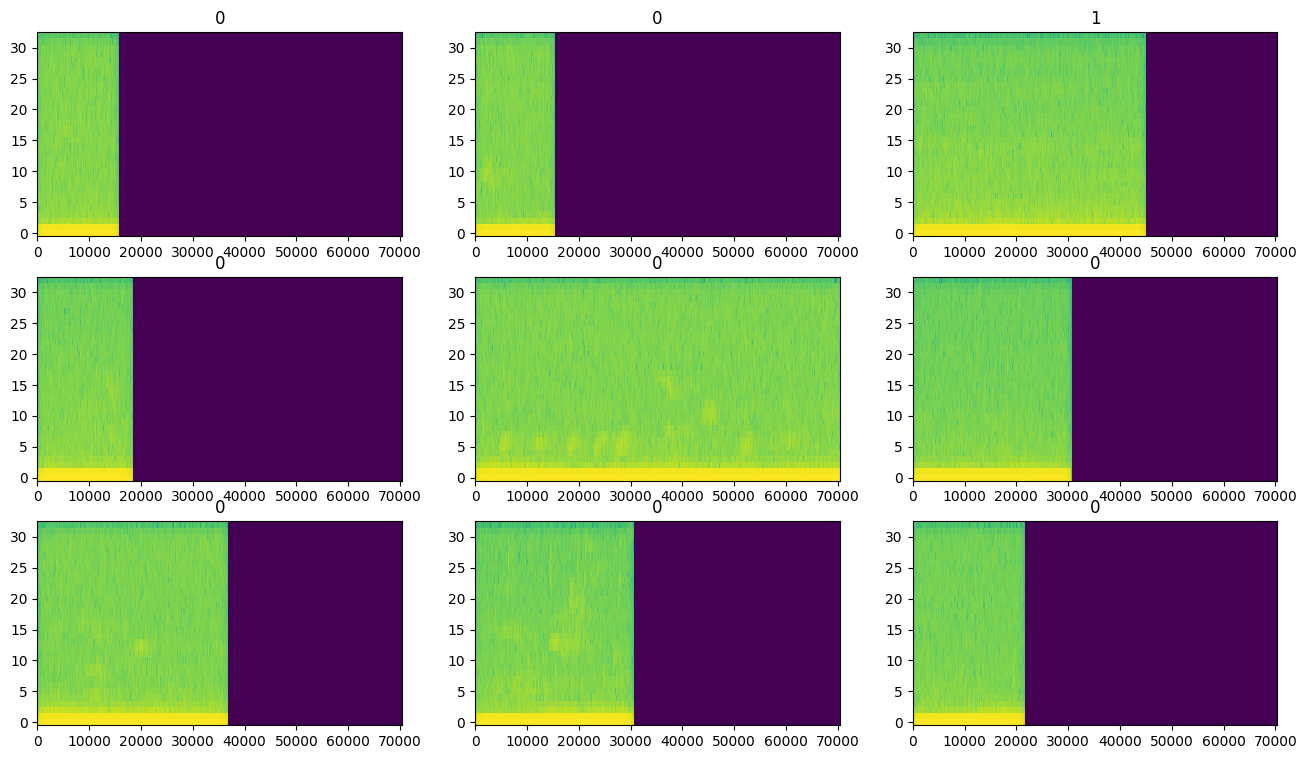

In [266]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

In [267]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

# Model Defination

In [268]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(1000,60),#(1000,60)
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    # layers.Conv2D(32, 3, activation='relu'),
    # layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (2132, 33, 1)
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_10 (Resizing)      (None, 1000, 60, 1)       0         
                                                                 
 normalization_10 (Normaliza  (None, 1000, 60, 1)      3         
 tion)                                                           
                                                                 
 conv2d_30 (Conv2D)          (None, 998, 58, 32)       320       
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 499, 29, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_31 (Conv2D)          (None, 497, 27, 32)       9248      
                                                                 
 max_pooling2d_31 (MaxPool

In [269]:
#compile the model and set optimizer and loss,accuracu metrics.
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

# Model Training

In [270]:
#train the model for atmost 15 epochs and stop it if it overfits twice
EPOCHS = 15
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/15
365/365 [==============================] - 24s 65ms/step - loss: 0.3569 - accuracy: 0.8358 - val_loss: 0.3047 - val_accuracy: 0.8742
Epoch 2/15
365/365 [==============================] - 24s 66ms/step - loss: 0.2415 - accuracy: 0.8920 - val_loss: 0.1945 - val_accuracy: 0.9141
Epoch 3/15
365/365 [==============================] - 22s 61ms/step - loss: 0.1659 - accuracy: 0.9318 - val_loss: 0.0988 - val_accuracy: 0.9672
Epoch 4/15
365/365 [==============================] - 25s 68ms/step - loss: 0.0584 - accuracy: 0.9797 - val_loss: 0.0173 - val_accuracy: 0.9930
Epoch 5/15
365/365 [==============================] - 23s 62ms/step - loss: 0.0166 - accuracy: 0.9948 - val_loss: 0.0109 - val_accuracy: 0.9977
Epoch 6/15
365/365 [==============================] - 23s 64ms/step - loss: 0.0096 - accuracy: 0.9970 - val_loss: 0.0100 - val_accuracy: 0.9969
Epoch 7/15
365/365 [==============================] - 23s 62ms/step - loss: 0.0076 - accuracy: 0.9976 - val_loss: 0.0142 - val_accuracy:

# Inspecting Model accuracy and loss

Text(0, 0.5, 'Accuracy [%]')

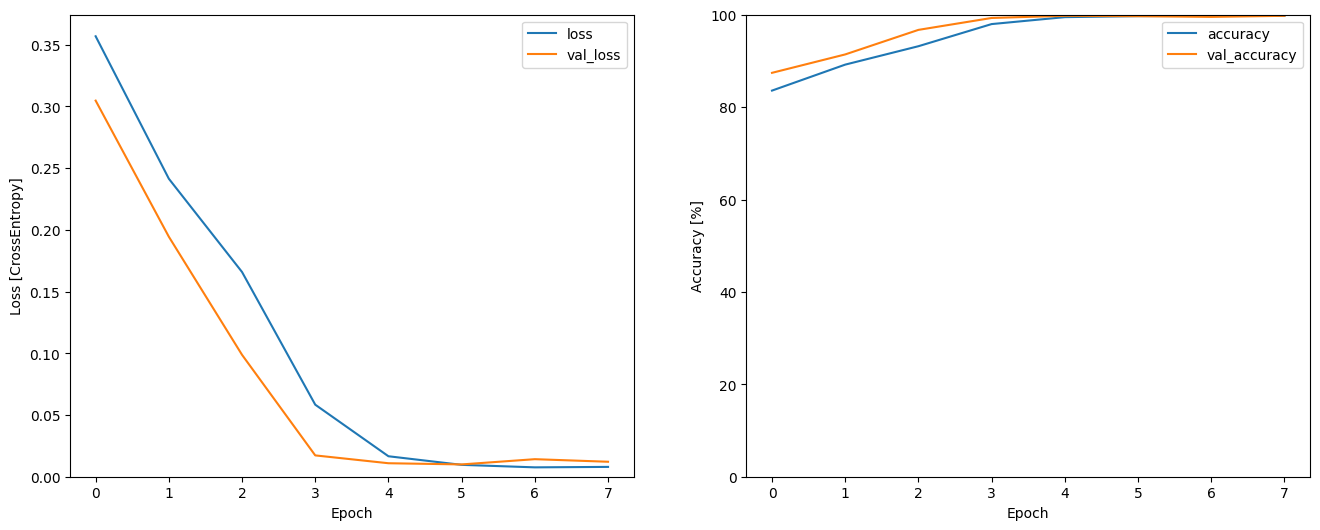

In [271]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

A confusion matrix is draw to see the performance of the model and it soes seem of some negative error prediction rate.

21/21 [==============================] - 0s 14ms/step


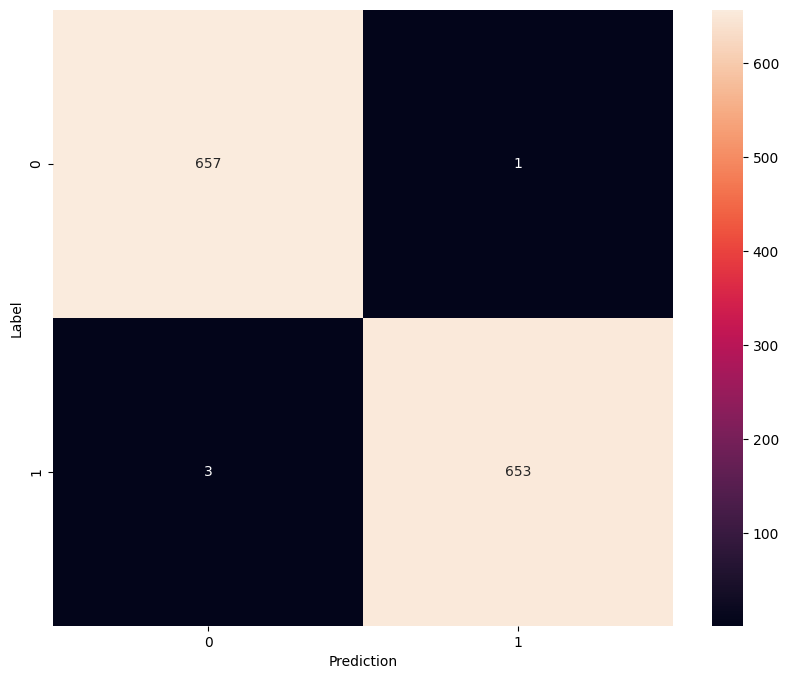

In [272]:
model.evaluate(test_spectrogram_ds, return_dict=True)
y_pred = model.predict(test_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [273]:
#mean-f1 score is calculated using the test data which the model has never seen before
from sklearn.metrics import f1_score
f1_score(y_true,y_pred, average="macro") # best mean-f1 score achived during fine tuning is 0.9961947698646625

0.9969558317598952

False-positives and False-negatives are manually inspected.

In [274]:
# test_dir = pathlib.Path('train/train/0')
# y=[]
# for i in range(1,12952):
#     x = test_dir/f'0{i}.wav'
#     # print(x)
#     x = tf.io.read_file(str(x))
#     x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=64000,)
#     x = tf.squeeze(x, axis=-1)
#     waveform = x
#     x = get_spectrogram(x)
#     x = x[tf.newaxis,...]
#     pred = model(x)
#     if int(tf.argmax(pred,axis=1))!=0:y.append(i)
# y

In [275]:
# test_dir = pathlib.Path('train/train/1')
# y1=[]
# for i in range(1,12996):
#     x = test_dir/f'0{i}.wav'
#     # print(x)
#     x = tf.io.read_file(str(x))
#     x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=64000,)
#     x = tf.squeeze(x, axis=-1)
#     waveform = x
#     x = get_spectrogram(x)
#     x = x[tf.newaxis,...]
#     pred = model(x)
#     if int(tf.argmax(pred,axis=1))!=1:y1.append(i)
# y1

# Saving the model architecture and Weights

# Predicting labels for actual Test data

In [276]:
# path to the test data folder
test_dir = pathlib.Path('test/test/')
y=[] # predicted labels are appended to this list
for i in range(2000):
    x = test_dir/f'{i}.wav'
    x = tf.io.read_file(str(x))
    x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=64000,)
    x = tf.squeeze(x, axis=-1)
    waveform = x
    x = get_spectrogram(x)
    x = x[tf.newaxis,...]
    pred = model(x)
    y.append(int(tf.argmax(pred, axis=1)))

In [277]:
# labels are saved to a csv file for submission
import pandas as pd
df=pd.DataFrame({'id':[*range(2000)],'label':y})
df.to_csv('Submissions/submission_new.csv',index=0)